Detection in whole pyramidal layer
==================================

In [2]:
import os

import numpy as np
from numpy import ma
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as anm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

import plotly.express as px

from skimage.util import montage
from skimage.filters import rank
from skimage import morphology
from skimage import exposure
from skimage import measure
from skimage import filters
from skimage import io

from scipy import ndimage as ndi
from scipy import signal
from scipy import stats

import cv2

from domb.reg_type import wf_x2_m2 as WF
from domb.fret.e_fret.e_app import Eapp
from domb.red_green import wt_vs_mut_multistim
from domb.utils import plot
from domb.utils.plot import CMaps
from domb.utils import masking
from domb.utils import oiffile

# OIB-tiff converter

In [4]:
wd_path = '/home/wisstock/bio_data/GLT_NeuN/fin_data'
for root, dirs, files in os.walk(wd_path):  # loop over OIF files
    for file in files:
        if file.endswith('.oib'):
            data_path = os.path.join(root, file)
            data = oiffile.OibImread(data_path)
            data_name = file.split('.')[0]
            io.imsave(f'{wd_path}/{data_name}.tif', data)

/tmp/ipykernel_6409/4104029977.py:8: UserWarning: /home/wisstock/bio_data/GLT_NeuN/fin_data/NeuN_GLT_3D_cef_5.tif is a low contrast image
  io.imsave(f'{wd_path}/{data_name}.tif', data)
/tmp/ipykernel_6409/4104029977.py:8: UserWarning: /home/wisstock/bio_data/GLT_NeuN/fin_data/NeuN_GLT_32.tif is a low contrast image
  io.imsave(f'{wd_path}/{data_name}.tif', data)
/tmp/ipykernel_6409/4104029977.py:8: UserWarning: /home/wisstock/bio_data/GLT_NeuN/fin_data/NeuN_GLT_13.tif is a low contrast image
  io.imsave(f'{wd_path}/{data_name}.tif', data)
/tmp/ipykernel_6409/4104029977.py:8: UserWarning: /home/wisstock/bio_data/GLT_NeuN/fin_data/NeuN_GLT_28.tif is a low contrast image
  io.imsave(f'{wd_path}/{data_name}.tif', data)
/tmp/ipykernel_6409/4104029977.py:8: UserWarning: /home/wisstock/bio_data/GLT_NeuN/fin_data/NeuN_GLT_3D_cef_2.tif is a low contrast image
  io.imsave(f'{wd_path}/{data_name}.tif', data)
/tmp/ipykernel_6409/4104029977.py:8: UserWarning: /home/wisstock/bio_data/GLT_NeuN/fin_d

# Input

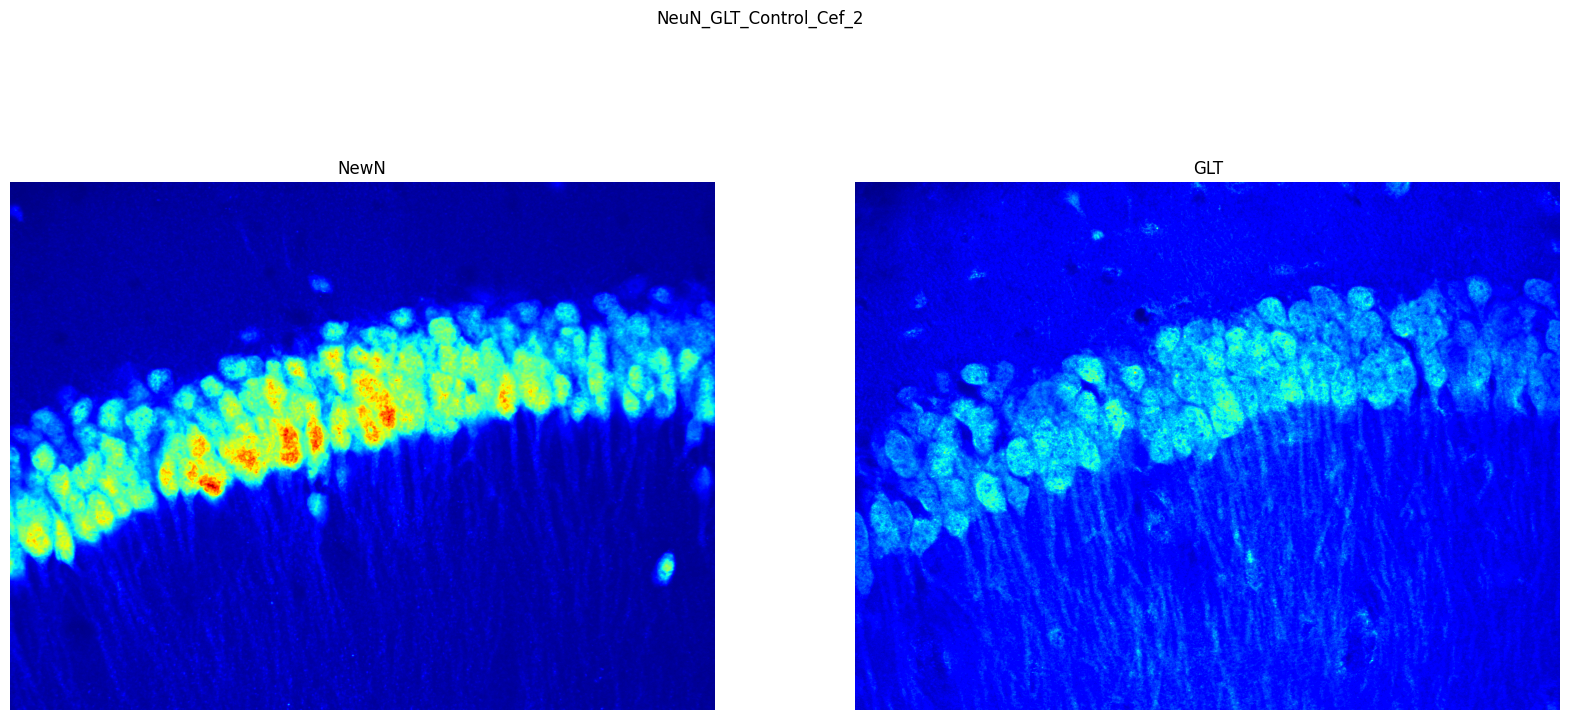

In [4]:
reg_path = '/home/wisstock/bio_data/GLT_NeuN/fin_data/NeuN+GLT_TBI_Control_Cef_completed/NeuN_GLT_Control_Cef_2.oib'
# reg_path = 'data/wt_vs_mut/23_06_23_11.tif'
reg_name = reg_path.split('/')[-1]
reg_name = reg_name.split('.')[0]

# img_raw = io.imread(reg_path)
img_raw = oiffile.OibImread(reg_path)

img_glt = img_raw[0]
img_neurons = img_raw[1]

plt.figure(figsize=(20,9))
ax0 = plt.subplot(121)
ax0.imshow(np.mean(img_neurons[5:], axis=0), cmap='jet')
ax0.set_title('NewN')
ax0.axis('off')
ax1 = plt.subplot(122)
ax1.imshow(np.max(img_glt, axis=0), cmap='jet')
ax1.set_title('GLT')
ax1.axis('off')
plt.suptitle(reg_name)
# plt.tight_layout
plt.show()

In [10]:
img_glt[::2,:,:].shape

(5, 1200, 1600)

# Soma det.

(-0.5, 1599.5, 1199.5, -0.5)

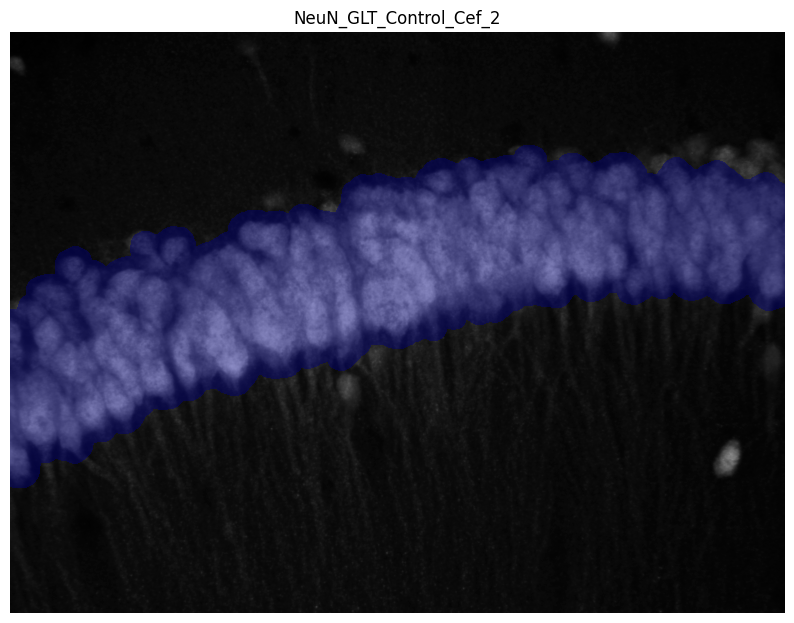

In [5]:
img_neurons_max = np.mean(img_neurons, axis=0)

neurons_th = filters.threshold_otsu(img_neurons_max)
mask_somas_raw = img_neurons_max > neurons_th

mask_somas = morphology.binary_dilation(mask_somas_raw, footprint=morphology.disk(25))
label_somas,_ = ndi.label(mask_somas)

def select_larg_mask(raw_mask):
    # get larger mask element
    element_label = measure.label(raw_mask)
    element_area = {element.area : element.label for element in measure.regionprops(element_label)}
    larger_mask = element_label == element_area[max(element_area.keys())]
    return larger_mask

mask_pyramid = select_larg_mask(mask_somas)
mask_pyramid = morphology.binary_dilation(mask_pyramid, footprint=morphology.disk(5))

plt.figure(figsize=(10,10))
plt.imshow(img_neurons_max*-1, cmap='Greys')
plt.imshow(ma.masked_where(~mask_pyramid, mask_pyramid), cmap='jet', alpha=.45)
plt.title(reg_name)
plt.axis('off')

# Glt dots det.

/home/wisstock/anaconda3/envs/domb/lib/python3.9/site-packages/skimage/filters/rank/generic.py:268: UserWarning: Bad rank filter performance is expected due to a large number of bins (2314), equivalent to an approximate bitdepth of 11.2.
  image, footprint, out, mask, n_bins = _preprocess_input(image, footprint,


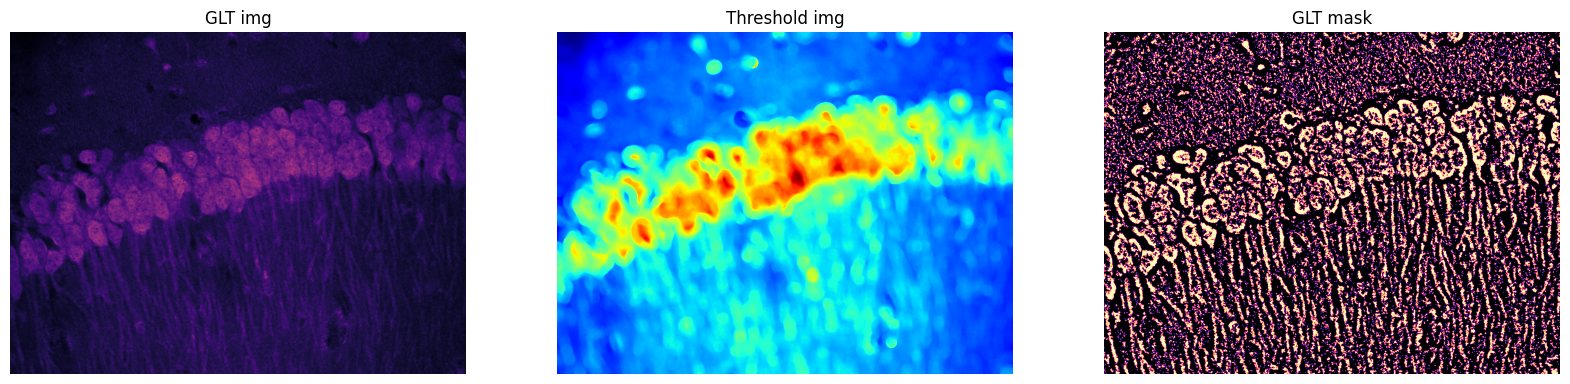

In [6]:
img_glt_max = np.max(img_glt, axis=0)
# glt_th = filters.threshold_niblack(img_glt_max, window_size=31, k=.0)
glt_th = rank.otsu(img_glt_max, footprint=morphology.disk(20))
# glt_th = filters.threshold_otsu(img_glt_max)

mask_glt_raw = img_glt_max > glt_th  # filters.threshold_minimum(img_glt_max)
mask_glt  = morphology.opening(mask_glt_raw, footprint=morphology.disk(1))

plt.figure(figsize=(20,20))
ax2 = plt.subplot(131)
ax2.imshow(img_glt_max, cmap='magma')
ax2.axis('off')
ax2.set_title('GLT img')
ax0 = plt.subplot(132)
ax0.imshow(glt_th, cmap='jet')
ax0.axis('off')
ax0.set_title('Threshold img')
ax1 = plt.subplot(133)
ax1.imshow(mask_glt, cmap='magma')
ax1.axis('off')
ax1.set_title('GLT mask')
plt.tight_layout
plt.show()


(-0.5, 1599.5, 1199.5, -0.5)

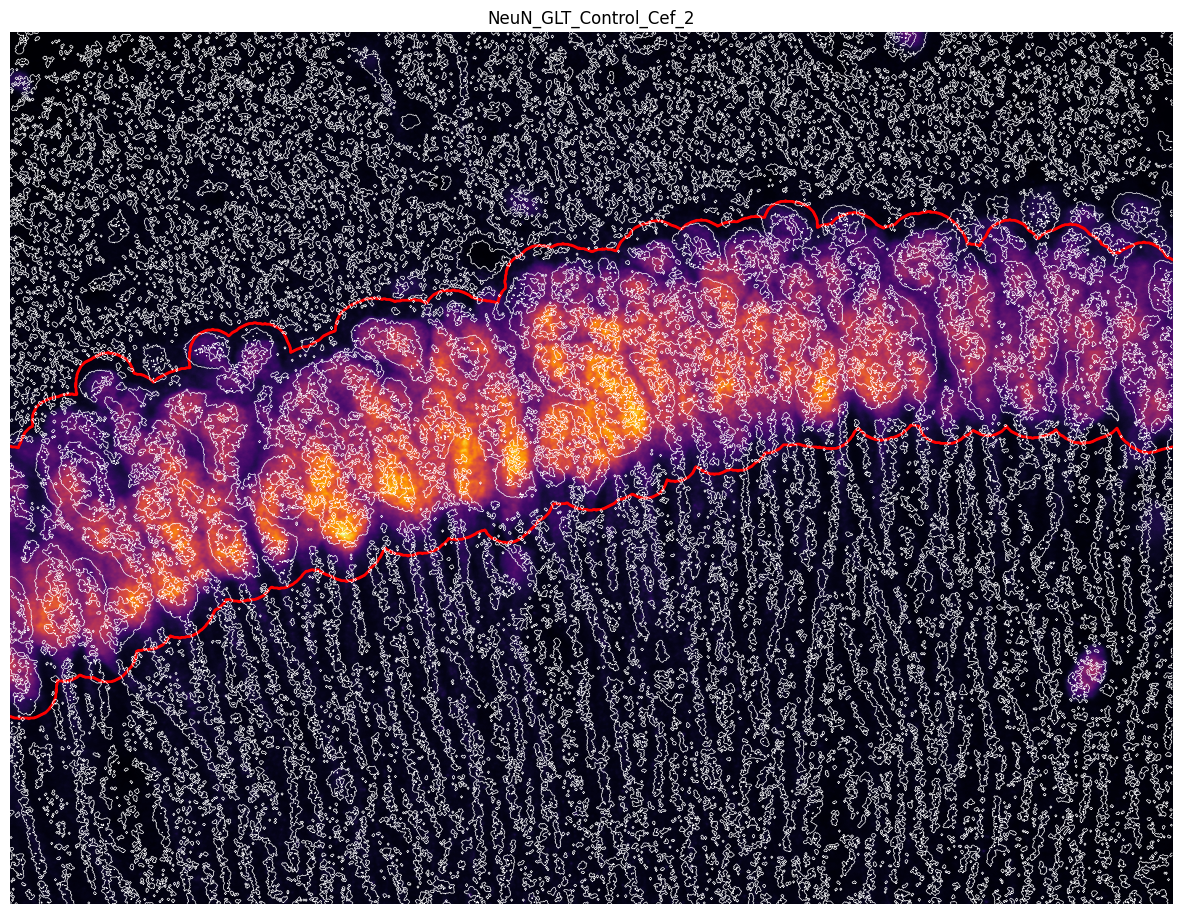

In [7]:
pyramid_contour = measure.find_contours(mask_pyramid, level=0.5)
glt_contour = measure.find_contours(mask_glt, level=0.5)

plt.figure(figsize=(15,15))
plt.imshow(img_neurons_max, cmap='inferno')
# plt.imshow(ma.masked_where(~mask_glt, mask_glt), cmap='Greys')
for p_c in pyramid_contour:
    plt.plot(p_c[:, 1], p_c[:, 0], linewidth=2, color='r')
for g_c in glt_contour:
    plt.plot(g_c[:, 1], g_c[:, 0], linewidth=0.5, color='w')
plt.title(reg_name)
plt.axis('off')